# Regressorion with Orbit

In this demo, we want to demonstartate how to use the different arguments in the model classes (LGT or DLT) to realize different setups for the regressors. Those could be very useful in practice when tuning the models.

In [1]:
import pandas as pd
import numpy as np

# from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

from orbit.dlt import DLT
from orbit.lgt import LGT

from orbit.utils.plot import plot_posterior_params
from orbit.constants.palette import QualitativePalette

In [2]:
print(np.__version__)

1.18.2


## Simulate Regressions

In [3]:
SERIES_LEN = 200
CYCLE_LEN = 52
COEFS_MU, COEFS_SIGMA = 0.08, 0.03
NUM_COEFS = 5
SEED = 2020

In [4]:
COEFS = np.random.default_rng(SEED).normal(COEFS_MU, COEFS_MU, NUM_COEFS)
COEFS

array([ 0.18081653,  0.09785428,  0.1866039 , -0.03345637,  0.05817624])

In [5]:
NOISE_TO_SIGNAL_RATIO = 0.5

In [6]:
# probabily of a signal appear
OBS_REG_PROB = 0.5
# scale and location parms of regressor values in log-scale
OBS_REG_LOG_LOC = 0.0
OBS_REG_LOG_SCALE = 0.2
# noise scale in log-scale
OBS_LOG_SCALE = NOISE_TO_SIGNAL_RATIO * OBS_REG_LOG_SCALE
# observation scale adjustment
OBS_BASE = 1000
REG_BASE = 1000

In [7]:
X_LOG = np.random.default_rng(SEED).normal(OBS_REG_LOG_LOC, OBS_REG_LOG_SCALE, SERIES_LEN * NUM_COEFS).reshape(SERIES_LEN, -1)
X_LOG[X_LOG < 0] = 0
Z = np.random.default_rng(SEED).binomial(1, OBS_REG_PROB, SERIES_LEN * NUM_COEFS).reshape(SERIES_LEN, -1)
X_LOG = X_LOG * Z
NOISE =  np.random.default_rng(SEED).normal(0, OBS_LOG_SCALE, SERIES_LEN)

In [8]:
print(X_LOG.shape, COEFS.shape, NOISE.shape) 

(200, 5) (5,) (200,)


## Simulate Trend

### Random Walk

In [9]:
RW = np.random.default_rng(SEED).normal(0.001, 0.05, SERIES_LEN)
RW_LEVS = np.cumsum(RW)

### ARMA

In [10]:
# arparams = np.array([.25])
# maparams = np.array([.6])
# ar = np.r_[1, -arparams]
# ma = np.r_[1, maparams]
# arma_process = sm.tsa.ArmaProcess(ar, ma)
# ARMA_LEVS = arma_process.generate_sample(SERIES_LEN)
# plt.plot(ARMA_LEVS)

## Simulate Seasonality

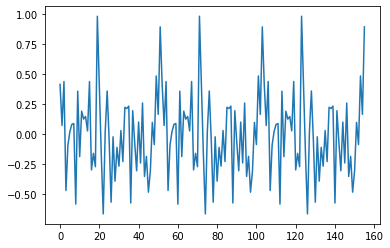

In [11]:
INIT_SEAS = np.zeros(CYCLE_LEN)
INIT_SEAS[:-1] = np.random.default_rng(SEED).normal(0, 0.33, CYCLE_LEN - 1)
INIT_SEAS[CYCLE_LEN - 1] = -1 * np.sum(INIT_SEAS)
SEAS = np.repeat([INIT_SEAS], int(SERIES_LEN/CYCLE_LEN), axis=0).reshape(-1,)
plt.plot(SEAS)

In [12]:
# Y =  OBS_BASE * np.exp(ARMA_LEVS + np.matmul(X_LOG, COEFS) + NOISE)
Y = np.round(OBS_BASE * np.exp(RW_LEVS + np.matmul(X_LOG, COEFS) + NOISE))

In [13]:
X = np.round(np.expm1(X_LOG) * REG_BASE) 

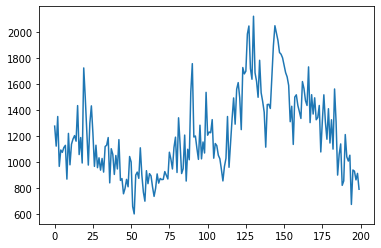

In [14]:
plt.plot(Y)

## Data Setup

Package response and signals into data frame

In [15]:
Y = Y.reshape(-1, 1)
print(Y.shape)

(200, 1)


In [16]:
# datetime index
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq='7D')
response_col = "acqusition"
regressor_cols = [f"regressor_{x}" for x in range(1, NUM_COEFS + 1)]
raw_df = pd.DataFrame(np.concatenate([Y, X], axis=1), columns = [response_col] + regressor_cols)

In [17]:
raw_df['week'] = dt 

In [18]:
raw_df.head(3)

,acqusition,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,week
0,1277.0,0.0,46.0,305.0,0.0,0.0,2016-01-04
1,1123.0,13.0,51.0,56.0,0.0,0.0,2016-01-11
2,1351.0,0.0,124.0,80.0,94.0,17.0,2016-01-18


## Estimating Coefficients

the only observations available is the data frame `df` and the scaler `REG_BASE`

In [19]:
df = raw_df.copy()
df[regressor_cols] = df[regressor_cols]/REG_BASE
df[regressor_cols] = df[regressor_cols].apply(np.log1p)
df[response_col] = np.log(df[response_col])

In [20]:
# coef_summary_list = []
# for sigma_prior in np.arange(0.1, 1, 0.1):
#     print(f"Running sigma: {sigma_prior}")
#     mod = DLT(
#         response_col=response_col,
#         date_col="week",
#         regressor_col=regressor_cols,
#         seasonality=52,
#         seed=1,
#         predict_method='map',
#         sample_method='map',
#     #     predict_method='mean',
#     #     sample_method='mcmc',
#         is_multiplicative=False,
#     #     fix_regression_coef_sd=0,
#     #     regressor_sigma_sd=0.1,
# #         regressor_sign = ["+"] * NUM_COEFS,
#         regressor_sigma_prior = [sigma_prior] * NUM_COEFS,
#         num_warmup=4000,
#         num_sample=1000,
#     )
#     mod.fit(df=df)
#     temp = mod.get_regression_coefs()
#     temp['sigma_prior'] = sigma_prior
#     temp['truth'] = COEFS
#     coef_summary_list.append(temp)
# coef_summary = pd.concat(coef_summary_list, axis=0)
# coef_summary.groupby(by=['regressor'])[['sigma_prior','coefficient','truth']].plot.line(x = 'sigma_prior');

In [29]:
mod_lasso = LGT(
    response_col=response_col,
    date_col="week",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
#     predict_method='map',
#     sample_method='map',
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
#     fix_regression_coef_sd=0,
    lasso_scale=0.3,
#         regressor_sign = ["+"] * NUM_COEFS,
#     regressor_sigma_prior = [sigma_prior] * NUM_COEFS,
    regression_penalty='lasso',
    num_warmup=4000,
    num_sample=1000,
)
mod_lasso.fit(df=df)
# coef_summary = mod.get_regression_coefs()
# coef_summary['ground truth'] = COEFS
# coef_summary = coef_summary.rename({"coefficient":"posterior"}, axis=1)
# coef_summary

In [30]:
mod_auto_ridge = LGT(
    response_col=response_col,
    date_col="week",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
#     predict_method='map',
#     sample_method='map',
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
#     fix_regression_coef_sd=0,
#     regressor_sigma_sd=1,
    auto_ridge_scale=0.3,
#         regressor_sign = ["+"] * NUM_COEFS,
#     regressor_sigma_prior = [sigma_prior] * NUM_COEFS,
    regression_penalty='ridge',
    num_warmup=4000,
    num_sample=1000,
)
mod_auto_ridge.fit(df=df)
# coef_summary = mod.get_regression_coefs()
# coef_summary['ground truth'] = COEFS
# coef_summary = coef_summary.rename({"coefficient":"posterior"}, axis=1)
# coef_summary

In [31]:
mod_fixed_ridge = LGT(
    response_col=response_col,
    date_col="week",
    regressor_col=regressor_cols,
    seasonality=52,
    seed=SEED,
#     predict_method='map',
#     sample_method='map',
    predict_method='full',
    sample_method='mcmc',
    is_multiplicative=False,
#     fix_regression_coef_sd=0,
#     regressor_sigma_sd=5,
#         regressor_sign = ["+"] * NUM_COEFS,
#     regressor_sigma_prior = [sigma_prior] * NUM_COEFS,
    regression_penalty='fixed',
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge.fit(df=df)
# coef_summary = mod.get_regression_coefs()
# coef_summary['ground truth'] = COEFS
# coef_summary = coef_summary.rename({"coefficient":"posterior"}, axis=1)
# coef_summary

In [32]:
# p5, ridge_coef, p95 =np.quantile(mod_lasso.posterior_samples['rr_beta'], q=[0.05, 0.5, 0.95], axis=0)
coef_lasso = np.median(mod_lasso.posterior_samples['rr_beta'], axis=0)
coef_auto_ridge = np.median(mod_auto_ridge.posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge =np.median(mod_fixed_ridge.posterior_samples['rr_beta'], axis=0)

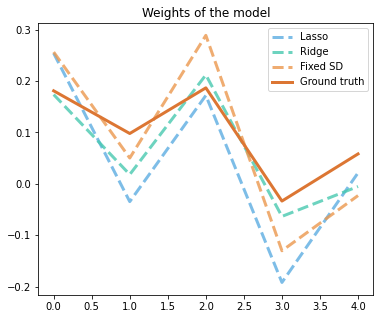

In [33]:
lw=3
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(coef_lasso, color=QualitativePalette.Q6.value[0], linewidth=lw, label="Lasso", alpha=0.8, linestyle='--')
plt.plot(coef_auto_ridge, color=QualitativePalette.Q6.value[1], linewidth=lw, label="Ridge", alpha=0.8, linestyle='--')
plt.plot(coef_fixed_ridge, color=QualitativePalette.Q6.value[2], linewidth=lw, label="Fixed SD", alpha=0.8, linestyle='--')
plt.plot(COEFS, color=QualitativePalette.Q6.value[3], linewidth=lw, label="Ground truth")
plt.legend()

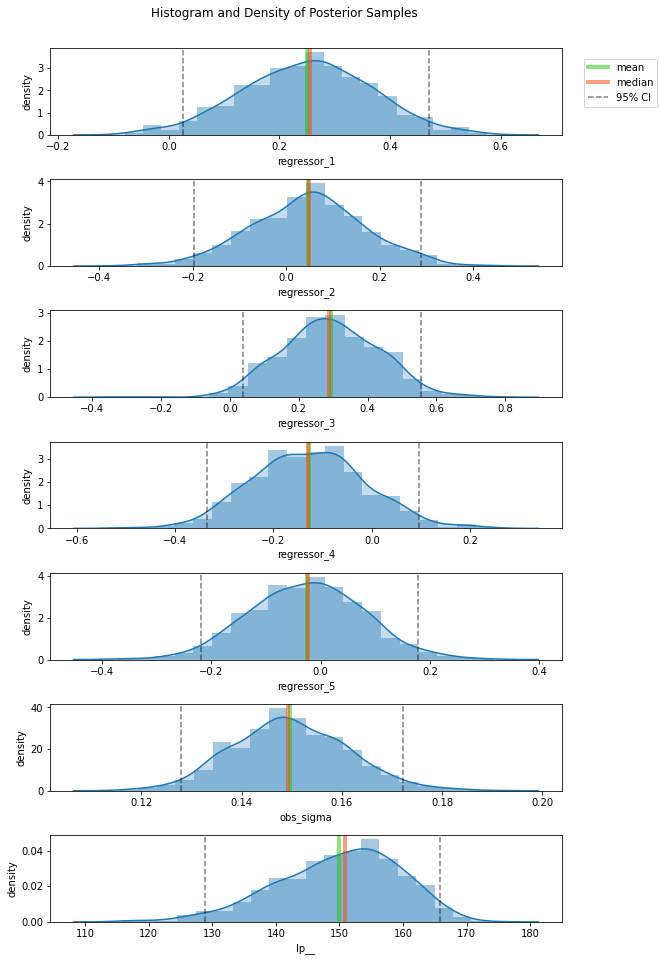

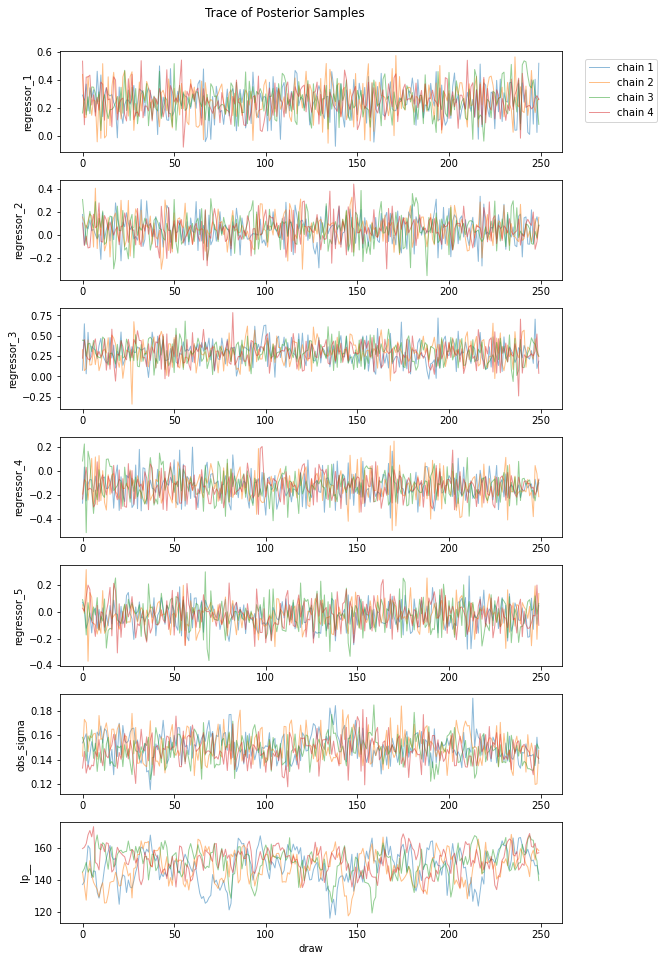

In [35]:
_ = mod_fixed_ridge.predict(df)
_ = plot_posterior_params(mod_fixed_ridge, kind='density')
_ = plot_posterior_params(mod_fixed_ridge, kind='trace')